Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 2.0902
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.0702
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0335 
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9183 
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9634 
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8945 
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8561 
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8342 
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9302 
Epoch 10/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8212 
Epoch 11/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8570 
Epoch 12/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9565 
Epoch 13/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7874 
Epoch 14/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7310  
Epoch 15/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6124 
Epoch 16/200
2/2 ━━

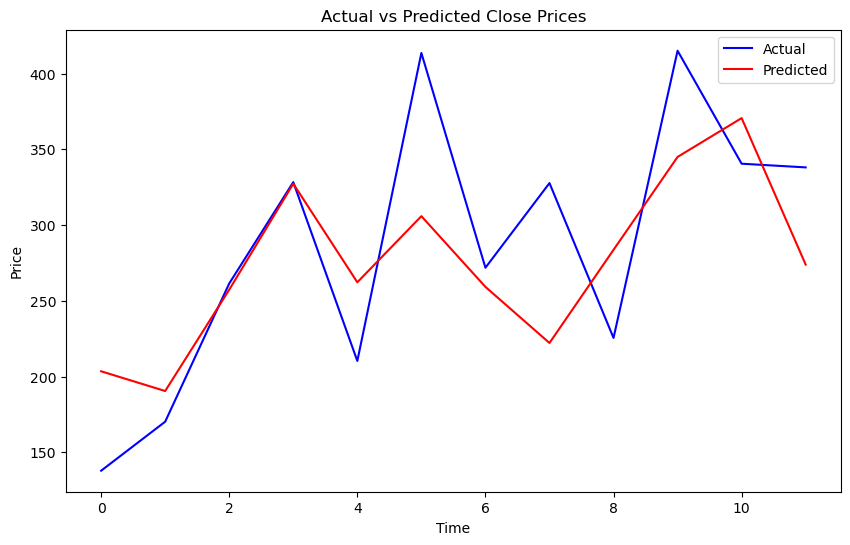

({'MSFT': array([[203.49544],
       [190.47957],
       [257.3812 ],
       [327.34424],
       [262.26456],
       [305.91626],
       [259.22592],
       [222.19154],
       [283.69592],
       [345.01834],
       [370.6464 ],
       [273.9247 ]], dtype=float32)}, {'MSFT': 0.5022157489016468})


In [43]:
import pandas as pd  
import numpy as np  
from sklearn.ensemble import GradientBoostingRegressor  
from sklearn.neighbors import KNeighborsRegressor  
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import StandardScaler  
from sklearn.metrics import r2_score  
from sklearn.preprocessing import MinMaxScaler  
from sklearn.preprocessing import StandardScaler
from yahoofinancials import YahooFinancials  
from datetime import datetime, timedelta   
from tensorflow import keras 
from tensorflow.keras import layers, losses, models, Model, optimizers
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Dense  
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
  
class PortfolioForecastService:  
    def __init__(self):  
        #self.yahoo_financials = YahooFinancials()
        self.end_date = None
        self.start_date = None
        self.historical_data = None
        
    def update(self, yahoo):
        self.end_date = datetime.now().strftime('%Y-%m-%d')  
        self.start_date = (datetime.now() - timedelta(days=5*365)).strftime('%Y-%m-%d')  
        self.historical_data = yahoo.get_historical_price_data(self.start_date, self.end_date, 'monthly')
  
    def get_historical_data(self,  symbol):  
        #end_date = datetime.now().strftime('%Y-%m-%d')  
        #start_date = (datetime.now() - timedelta(days=5*365)).strftime('%Y-%m-%d')  
        #historical_data = self.yahoo_financials.get_historical_price_data(start_date, end_date, 'monthly')[symbol]['prices']
        return pd.DataFrame(self.historical_data[symbol]['prices']) 
  
    def get_forecast_data(self, symbol, historical_data):    
        # Normalize the historical data  
        scaler_historical = StandardScaler()  
        historical_data_scaled = scaler_historical.fit_transform(historical_data)  
      
        # Create a separate scaler for the 'close' prices  
        close_scaler = StandardScaler()  
        close_prices = historical_data.iloc[:, 4].values.reshape(-1, 1)  # Assuming 'close' is the 5th column  
        close_scaler.fit(close_prices)  
              
        # Extract latent representations using the VAE    
        vae = self.VAE(historical_data_scaled)    
        latent_representations = vae.predict(historical_data_scaled)    
                
        # Generate synthetic stock price data using GAN    
        gan = self.GAN(latent_representations)    
        synthetic_data = gan.predict(latent_representations)    
      
        # Normalize synthetic data  
        scaler_synthetic = StandardScaler()  
        synthetic_data_scaled = scaler_synthetic.fit_transform(synthetic_data)  
      
        print("Synthetic data:", synthetic_data_scaled)   
                
        # Combine Latent Representations and Synthetic Data    
        enriched_data = np.concatenate((latent_representations, synthetic_data_scaled), axis=1)    
      
        print("Enriched data:", enriched_data)   

        print("Historical data:", historical_data_scaled)   
        
        X = enriched_data    
        y = historical_data_scaled[:, 4]  # Assuming 'close' is the 5th column  
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)      
      
        # Replace GradientBoostingRegressor with Sequential model  
        model = Sequential()      
        model.add(layers.Input(shape=(X_train.shape[1],)))  
        model.add(Dense(64, activation='relu'))      
        model.add(Dense(32, activation='relu'))      
        model.add(Dense(1))  


    
      
        model.compile(optimizer='adam', loss='mean_squared_error')    
        model.fit(X_train, y_train, epochs=200, batch_size=32)  
      
        y_pred = model.predict(X_test)      
          
        # Convert predictions back to original scale      
        y_pred_rescaled = close_scaler.inverse_transform(y_pred.reshape(-1, 1))      
      
        # Convert actual values back to original scale  
        y_test_rescaled = close_scaler.inverse_transform(y_test.reshape(-1, 1))  
      
        # Plot actual vs predicted values  
        plt.figure(figsize=(10, 6))  
        plt.plot(y_test_rescaled, color='blue', label='Actual')  
        plt.plot(y_pred_rescaled, color='red', label='Predicted')  
        plt.title('Actual vs Predicted Close Prices')  
        plt.xlabel('Time')  
        plt.ylabel('Price')  
        plt.legend()  
        plt.show()  
      
        score = r2_score(y_test, y_pred)        
      
        return y_pred_rescaled, score 
  
    def get_portfolio_forecast(self, portfolio):
        forecast_data = {}  
        accuracy_scores = {}
        yahoo = YahooFinancials(portfolio)
        self.update(yahoo)
        for symbol in portfolio:  
            historical_data = self.get_historical_data(symbol).drop("formatted_date", axis = 'columns')
            
            forecast, score = self.get_forecast_data(symbol, historical_data)  
            forecast_data[symbol] = forecast  
            accuracy_scores[symbol] = score  
        return forecast_data, accuracy_scores  
  
    def VAE(self, data):  
        latent_dim = data.shape[1] 
  
        class Encoder(Model):    
          def __init__(self, latent_dim):    
            super(Encoder, self).__init__()    
            self.dense = layers.Dense(latent_dim)  
            self.z_mean = layers.Dense(latent_dim)  
            self.z_log_var = layers.Dense(latent_dim)  
          
          def call(self, x):    
            x = self.dense(x)  
            z_mean = self.z_mean(x)  
            z_log_var = self.z_log_var(x)  
            return z_mean, z_log_var  
  
  
        class Decoder(Model):  
          def __init__(self, original_dim):  
            super(Decoder, self).__init__()   
            self.decoder = layers.Dense(data.shape[1], activation='sigmoid', activity_regularizer=keras.regularizers.l1(10e-5))  
  
          def call(self, x):  
            decoded = self.decoder(x)  
            return decoded  
  
        class VAE(Model):    
          def __init__(self, encoder, decoder, beta=0.1):    
            super(VAE, self).__init__()    
            self.encoder = encoder    
            self.decoder = decoder    
            self.beta = beta  
          
          def call(self, x):    
            self.z_mean, self.z_log_var = self.encoder(x)    
            z = self.z_mean + K.exp(0.5 * self.z_log_var) * K.random_normal(shape=(K.shape(x)[0], latent_dim))  
            decoded = self.decoder(z)  
            return decoded    
          
          def vae_loss(self, x, decoded):  
            self.z_mean, self.z_log_var = self.encoder(x)    
            reconstruction_loss = losses.MeanSquaredError()(x, decoded)  
            kl_loss = - 0.5 * K.sum(1 + self.z_log_var - K.square(self.z_mean) - K.exp(self.z_log_var), axis=-1)  
            return K.mean(reconstruction_loss + self.beta * kl_loss)  

        encoder = Encoder(latent_dim)      
        decoder = Decoder(data.shape[1]) 

        vae = VAE(encoder, decoder)  
        vae.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss=vae.vae_loss)  
  
        vae.fit(data, data, epochs=200, batch_size=32)    
      
        return vae  
  
    def GAN(self, data):    
        latent_dim = data.shape[1]   
        
        class Generator(keras.Model):      
            def __init__(self, latent_dim):          
                super(Generator, self).__init__()          
                self.generator = keras.Sequential([            
                layers.Input(shape=(latent_dim,)),       
                layers.Dense(128),       
                layers.LeakyReLU(negative_slope=0.2),            
                layers.BatchNormalization(momentum=0.8),            
                layers.Dense(256),            
                layers.LeakyReLU(negative_slope=0.2),            
                layers.BatchNormalization(momentum=0.8),            
                layers.Dense(512),            
                layers.LeakyReLU(negative_slope=0.2),            
                layers.BatchNormalization(momentum=0.8),  
                layers.Dense(512),  
                layers.LeakyReLU(negative_slope=0.2),   
                layers.BatchNormalization(momentum=0.8),  
                layers.Dense(latent_dim, activation='tanh'),
                layers.Dropout(0.2)
                ])   
      
            def call(self, x):    
                generated = self.generator(x)    
                return generated  
          
        class Discriminator(keras.Model):        
            def __init__(self, latent_dim):        
                super(Discriminator, self).__init__()        
                self.discriminator = keras.Sequential([      
                    layers.Input(shape=(latent_dim,)),  
                    layers.Dense(128),    
                    layers.LeakyReLU(negative_slope=0.2),      
                    layers.Dense(256),      
                    layers.LeakyReLU(negative_slope=0.2),   
                    layers.Dense(1),  
                    layers.Dropout(0.2)  
                ])    

          
            def call(self, x):    
                validity = self.discriminator(x)    
                return validity  
            
        class GAN(keras.Model):    
            def __init__(self, generator, discriminator):    
                super(GAN, self).__init__()    
                self.generator = generator    
                self.discriminator = discriminator    
          
            def call(self, x):    
                generated = self.generator(x)    
                validity = self.discriminator(generated)    
                return validity    
          
        generator = Generator(latent_dim)    
        discriminator = Discriminator(latent_dim)    
        gan = GAN(generator, discriminator)    
          
        gan.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss=losses.BinaryCrossentropy(from_logits=True))  
        gan.fit(data, np.ones((data.shape[0], 1)), epochs=200, batch_size=32)   
          
        return gan  
        
x = PortfolioForecastService()
print(x.get_portfolio_forecast(["MSFT"]))